# Практика по базовой математической статистике для Data scientist

# Практика 3 - построение доверительной оценки

На практическом занятии научимся строить доверительные интервалы и выделять аномалии при помощи python.

- Строим доверительный интервал для цен акций из yahoo finance при помощи scipy, numpy, pandas
-  Делаем выводы по наличию или отсутствию аномальных событий

Для начала импортируем все полезные библитеки и настроим ноутбук

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
from scipy import *
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

В этой практике мы поработаем с реальными финансовыми данными.
Наверняка каждый из нас хоть раз покупал доллары в надежде немного заработать на разнице курсов покупки и продажи. Но не каждый знает, что помимо валют есть ещё и другие финансовые инструменты - например, акции или облигации, с которыми работают профессиональные инвесторы на специальной площадке для купли и продаже - бирже.

Данные о ценах финансовых инструментов называются котировками, и сегодня мы с вами представим себя инвесторами и проанализируем реальные котировки самых настоящих акций.

Мы будем доставать их из сервиса yahoo finance, и для этого помощи bash магии установим несколько нужных библиотек.

In [ ]:
%%bash
pip install yfinance



In [ ]:
%%bash
pip install pandas-datareader

In [ ]:
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

In [ ]:
# Собираем котировки за интересующий период.
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 8, 31)

In [ ]:
df = yf.download("GOOG", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 2018-01-02 to 2019-08-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       419 non-null    float64
 1   High       419 non-null    float64
 2   Low        419 non-null    float64
 3   Close      419 non-null    float64
 4   Adj Close  419 non-null    float64
 5   Volume     419 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 22.9 KB


In [ ]:
# Переведем заголовки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

,open,high,low,close,adj close,volume
Date,,,,,,
2018-01-02,52.417000,53.347000,52.261501,53.250000,53.250000,24752000
2018-01-03,53.215500,54.314499,53.160500,54.124001,54.124001,28604000
2018-01-04,54.400002,54.678501,54.200100,54.320000,54.320000,20092000
2018-01-05,54.700001,55.212502,54.599998,55.111500,55.111500,25582000
2018-01-08,55.111500,55.563499,55.081001,55.347000,55.347000,20952000


Для изучения выберем разницу между ценой закрытия и ценой открытия.

In [ ]:
# Готовим новую метрику.
df["diff_price"] = df.close - df.open

Для построения доверительного интервала необходимо, чтобы исследумая величина была распределена по Гауссову закону.
Поэтому воспользуемся функцией из первой практики для разведочного анализа.

Text(0.5, 1.0, 'График разницы между ценой закрытия и открытия')

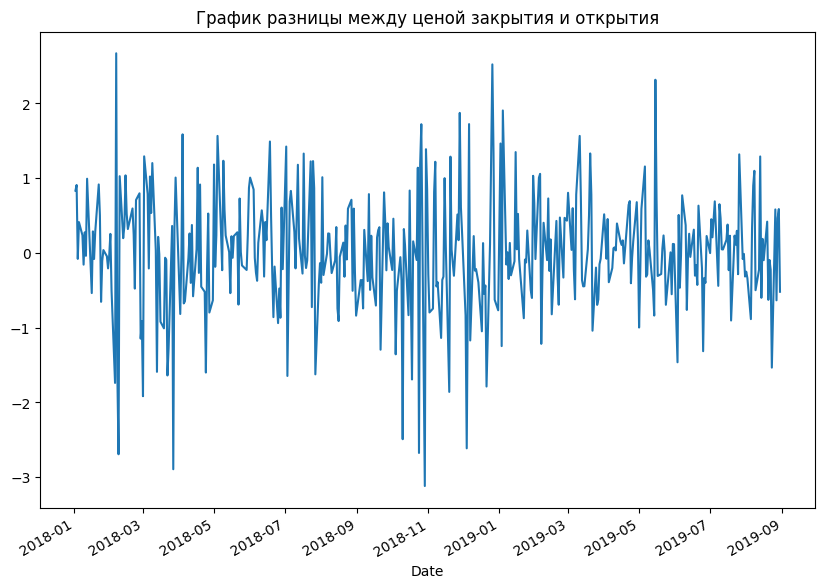

In [ ]:
df.diff_price.plot()
plt.title("График разницы между ценой закрытия и открытия")

In [ ]:
def my_basic_research(df=df, column = "diff_price"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")

    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")

    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))

    sns.distplot(df[column])
    plt.title("Распределение метрики")

Базовые метрики
count    419.000000
mean       0.014167
std        0.789271
min       -3.119499
25%       -0.375252
50%       -0.002502
75%        0.460249
max        2.670998
Name: diff_price, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
diff_price
 0.848000    2
-0.308498    2
-0.231499    2
-0.538502    2
 1.565498    2
Name: count, dtype: int64
------------------------------------
Эксцесс  1.8273103799452652
Ассиметрия  -0.37369326670455244


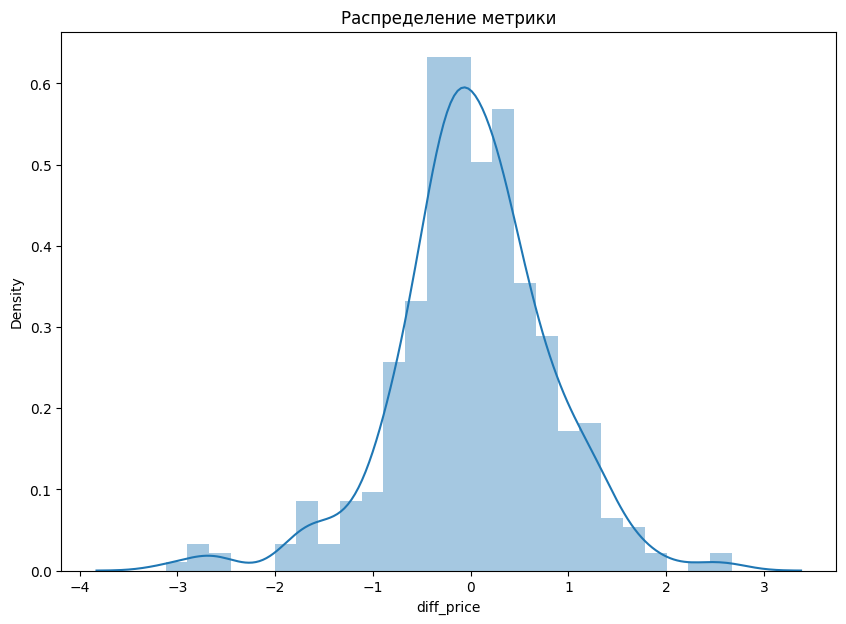

In [ ]:
my_basic_research(column = "diff_price")

В целом наше распределение близко к нормальному, несмотря на остроконечный пик и наличие выбросов.
Однако для уверенности проверим его при помощи графика QQ plot - https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot

График сравнивает квантили выборки и выбранноого распределения - в нашем случае, нормального.

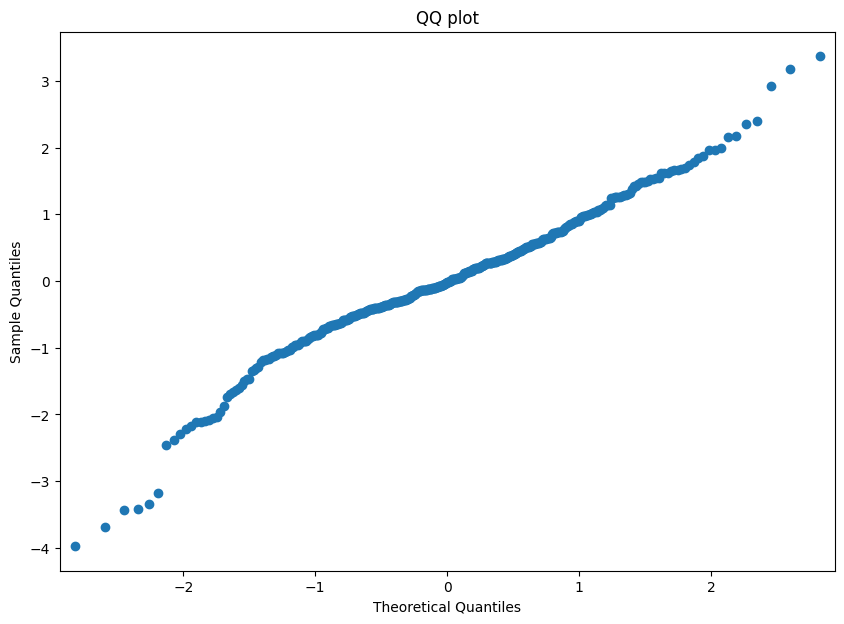

In [ ]:
sm.qqplot(df.diff_price, fit = True)
plt.title("QQ plot")
plt.show()

Кажется, что можно использовать стандартные доверительные интервалы для нормального распределения. Для этого воспользуемся функцией https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [ ]:
def my_norm_confidence(df=df, column = "diff_price", alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [ ]:
confidence = my_norm_confidence()
print(confidence)

(-1.532776016608467, 1.5611091479479657)


При доверительной вероятности 95 % средняя разница между ценой закрытия и открытия не выйдет за этот интервал.
Отметим на графике полученный коридор.

Text(0.5, 1.0, 'Доверительный интервал')

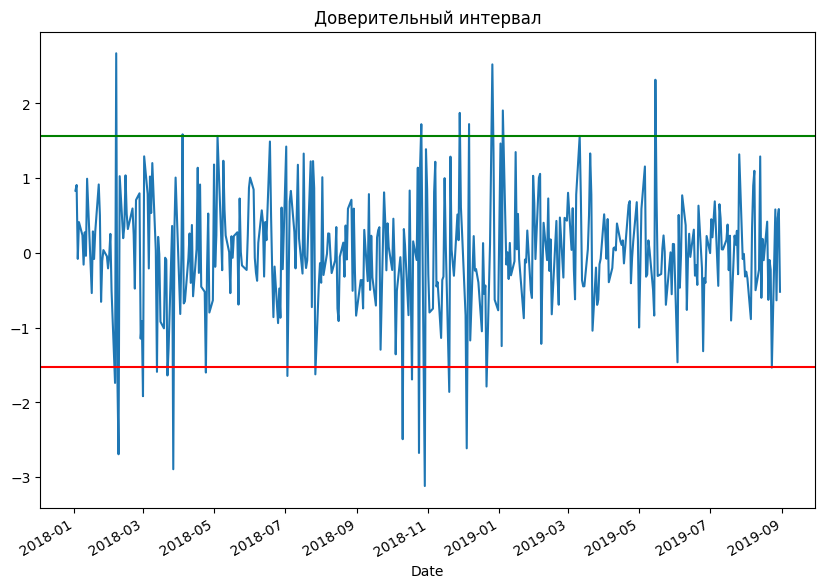

In [ ]:
df.diff_price.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

## Отбор аномалий при помощи доверительного интервала

А если нам понадобится отметить аномальные события, выходящие за зеленую границу, то это можно сделать следующим образом

In [ ]:
df["anomaly_big"] = np.where(df.diff_price > confidence[1], 1,0)

Теперь они готовы к дальнейшему исследованию.

In [ ]:
df[df.anomaly_big == 1].describe()

,open,high,low,close,adj close,volume,diff_price,anomaly_big
count,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.0
mean,52.207301,54.409340,52.025955,54.152600,54.152600,5.155860e+07,1.945299,1.0
std,2.496866,2.530910,2.547175,2.480877,2.480877,1.477136e+07,0.411089,0.0
min,49.450500,51.435902,49.150002,51.257000,51.257000,3.438400e+07,1.565498,1.0
25%,50.973501,52.704624,50.922963,52.667000,52.667000,4.285500e+07,1.620374,1.0
50%,51.671251,53.822750,51.454700,53.554501,53.554501,4.848700e+07,1.798500,1.0
75%,52.291375,55.080375,51.767123,54.241125,54.241125,5.396150e+07,2.214248,1.0
max,57.222500,58.809502,57.222500,58.787998,58.787998,8.375200e+07,2.670998,1.0


# Мини домашка

Необходимо построить для тех же данных доверительный интервал с доверительной вероятностью 90 %
Сколько аномальных событий находится выше верхней доверительной границы?

In [ ]:
confidence_90 = my_norm_confidence(alpha=0.9)
confidence

(-1.532776016608467, 1.5611091479479657)

In [ ]:
df['anomaly_big_90'] = np.where(df.diff_price > confidence_90[1], 1,0)

In [ ]:
df[df.anomaly_big_90 == 1].describe()

,open,high,low,close,adj close,volume,diff_price,anomaly_big,anomaly_big_90
count,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.0
mean,53.605448,55.509626,53.405660,55.283447,55.283447,4.776063e+07,1.678000,0.526316,1.0
std,3.642578,3.588238,3.750988,3.515747,3.515747,1.909615e+07,0.412453,0.512989,0.0
min,49.450500,51.435902,49.150002,51.257000,51.257000,2.434600e+07,1.318501,0.000000,1.0
25%,50.851250,52.520750,50.815250,52.351500,52.351500,3.329600e+07,1.368250,0.000000,1.0
50%,51.851501,54.085499,51.704498,53.857498,53.857498,4.454800e+07,1.565498,1.000000,1.0
75%,56.538000,58.641001,56.506401,58.441750,58.441750,5.253900e+07,1.798500,1.000000,1.0
max,61.202000,63.277500,61.200001,62.520500,62.520500,9.611600e+07,2.670998,1.000000,1.0


Text(0.5, 1.0, 'Доверительный интервал')

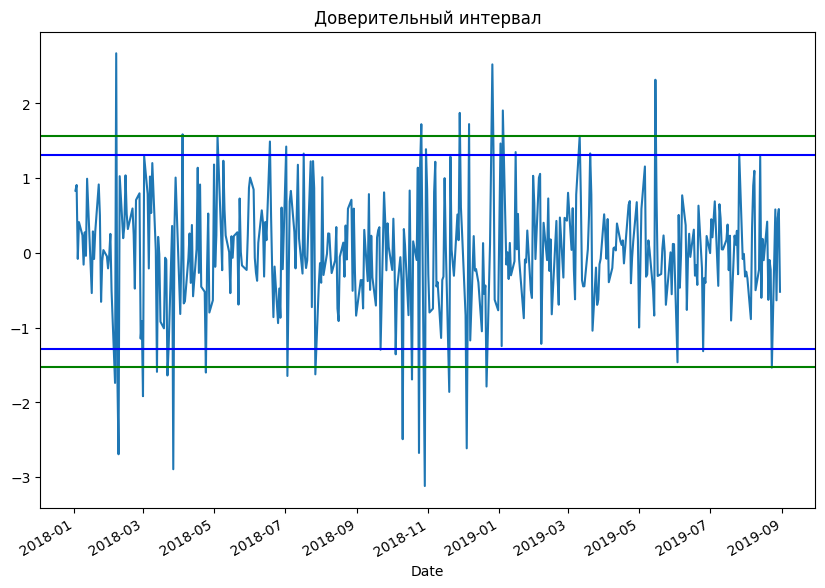

In [ ]:
df.diff_price.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="g", linestyle="-")
plt.axhline(y=confidence_90[1], color="b", linestyle="-")
plt.axhline(y=confidence_90[0], color="b", linestyle="-")
plt.title("Доверительный интервал")